In [1]:
from utils import *

import time
import numpy as np

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

import ta

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
context = mx.cpu(); model_ctx = mx.cpu()
mx.random.seed(890)

In [4]:
df = pd.read_csv('GS_closing.csv')
df.drop(columns="Unnamed: 0", inplace=True)
df.rename(columns={"Close":"price"}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
df.columns

Index(['Date', 'price'], dtype='object')

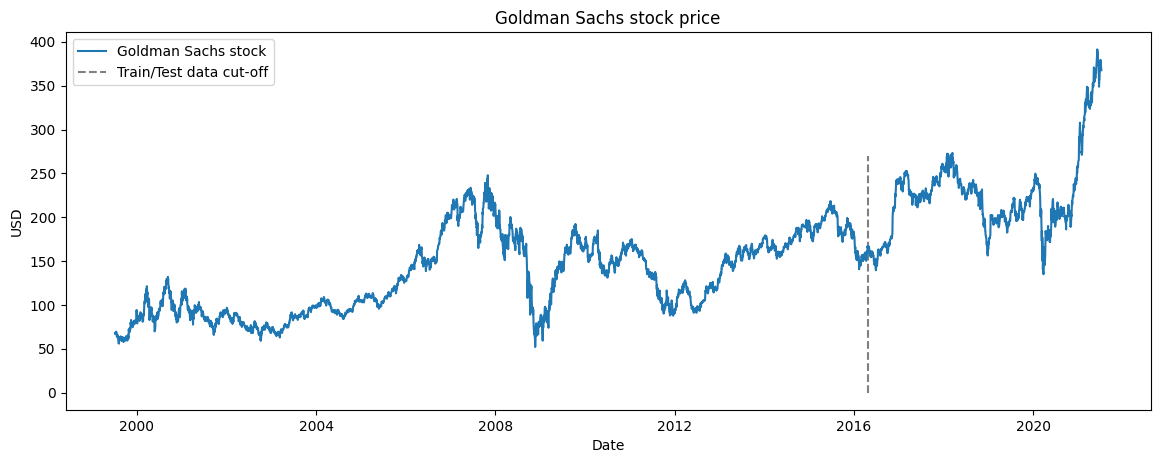

In [6]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(df['Date'], df['price'], label='Goldman Sachs stock')
plt.vlines(datetime.date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Goldman Sachs stock price')
plt.legend()
plt.show()

In [7]:
num_training_days = int(df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    df.shape[0]-num_training_days))

Number of training days: 3875. Number of test days: 1661.


## Technical Indicators

In [152]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['price'].rolling(window=7, min_periods=1).mean()
    dataset['ma21'] = dataset['price'].rolling(window=21, min_periods=1).mean()
    
    # Create MACD
    dataset['26ema'] = ta.trend.ema_indicator(dataset['price'], window=12, fillna=True)
    dataset['12ema'] = ta.trend.ema_indicator(dataset['price'], window=12, fillna=True)
    dataset['MACD'] = ta.trend.macd(dataset['price'], window_slow=26, window_fast=12, fillna=True)

    # Create Bollinger Bands
    dataset['upper_band'] = ta.volatility.bollinger_hband(df['price'], window=20, window_dev=2, fillna=True)
    dataset['lower_band'] = ta.volatility.bollinger_lband(df['price'], window=20, window_dev=2, fillna=True)
    
    # Create Schaff Trend Cycle
    dataset['STC'] = ta.trend.stc(df['price'], window_slow=50, window_fast=23, cycle=10, smooth1=3, smooth2=3, fillna=True)
    
    # Create Momentum
    dataset['momentum'] = dataset['price']-1
    
    return dataset

In [153]:
dataset_TI_df = get_technical_indicators(df.rename(columns={'GS':"price"}))

In [154]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['price'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(np.log(dataset['momentum']),label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

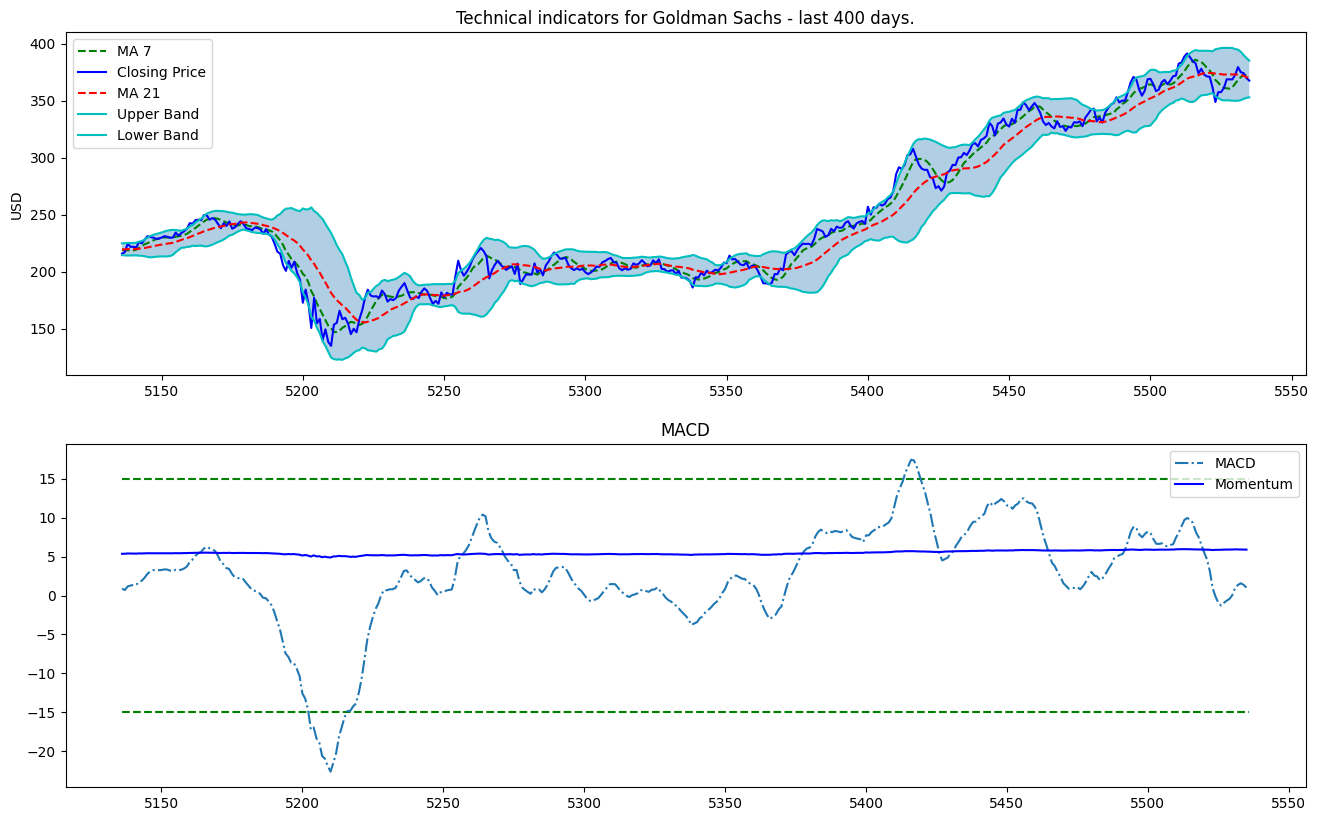

In [155]:
plot_technical_indicators(dataset_TI_df, 400)

In [156]:
df = dataset_TI_df

## Fourier Transform

In [13]:
close_fft = np.fft.fft(np.asarray(df['price'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

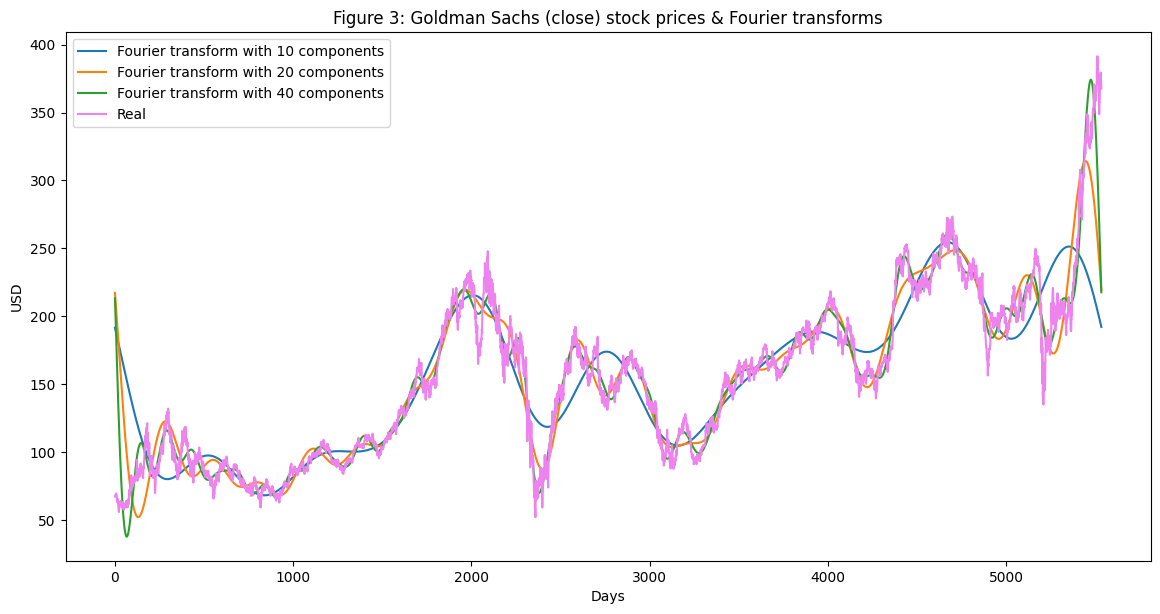

In [51]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [10, 20, 40]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.abs(np.fft.ifft(fft_list_m10)), label='Fourier transform with {} components'.format(num_))
    
    if f'FT_{num_}' not in df.columns:
        df[f'FT_{num_}'] = np.abs(np.fft.ifft(fft_list_m10))

plt.plot(df['price'],  label='Real', c='violet')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

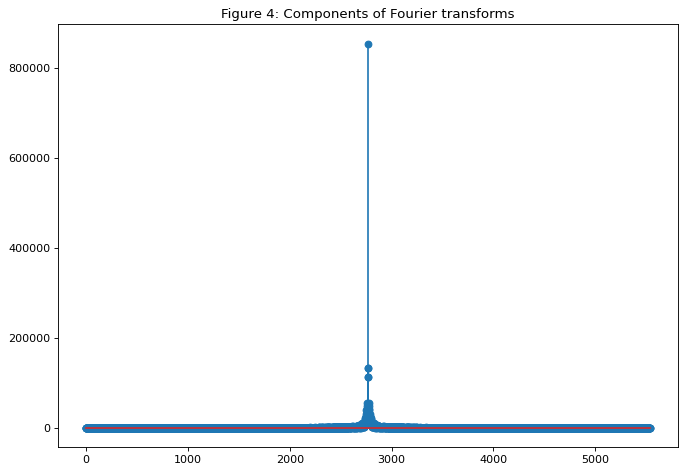

In [15]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

## ARIMA as a feature

In [22]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = df['price']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                 5535
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -14365.376
Method:                       css-mle   S.D. of innovations              3.243
Date:                Thu, 08 Jul 2021   AIC                          28744.753
Time:                        15:40:09   BIC                          28791.085
Sample:                             1   HQIC                         28760.908
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0543      0.040      1.352      0.176      -0.024       0.133
ar.L1.D.price    -0.0605      0.013     -4.503      0.000      -0.087      -0.034
ar.L2.D.price     0.0179      0.013     

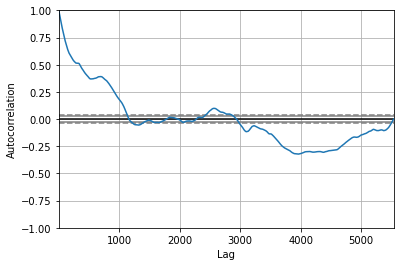

<Figure size 800x560 with 0 Axes>

In [23]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [24]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [25]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 13.328


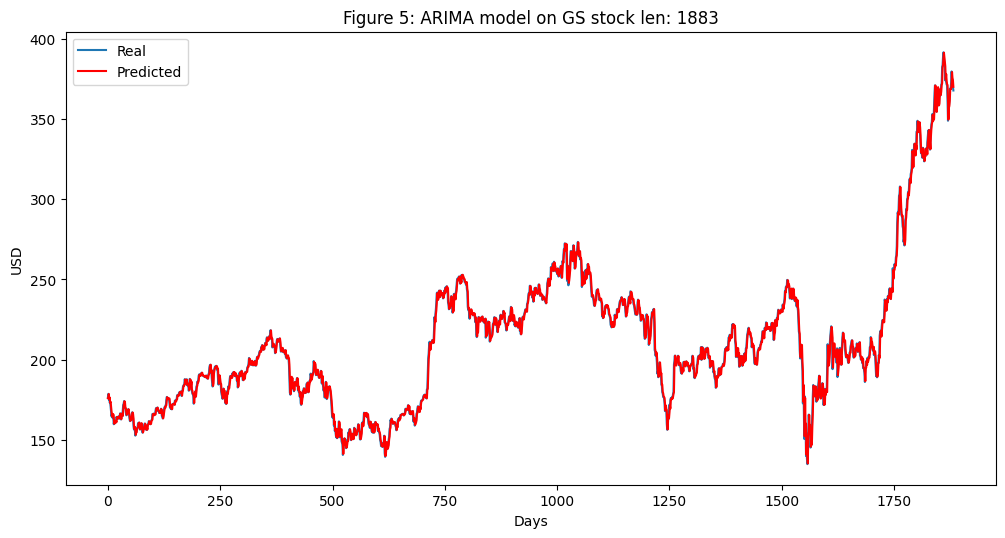

In [29]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title(f'Figure 5: ARIMA model on GS stock len: {len(predictions)}')
plt.legend()
plt.show()

## Feature Importance using XGBoost

In [158]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['price']
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [159]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(df.drop(columns=['Date', 'momentum']))


In [160]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)


In [161]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)


In [162]:
eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

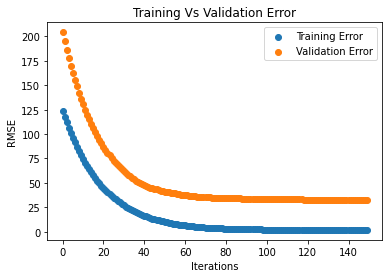

In [163]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

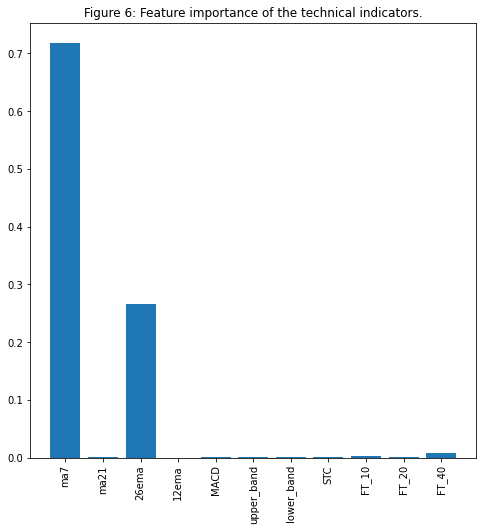

In [164]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

### Autoencoder for feature extraction

In [197]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
import tensorflow as tf
from tensorflow.keras import losses
import numpy as np

In [198]:
X = df.drop(columns=["price", "Date"]).values
y = df['price'].values

In [199]:
n_inputs = X.shape[1]
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [200]:
t = StandardScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

In [201]:
class Autoencoder(Model):
  def __init__(self, latent_dim, output_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
        Dense(40, activation='relu'),
        Dense(latent_dim, activation='relu')
    ])
    self.decoder = tf.keras.Sequential([
        Dense(40, activation='relu'),
        Dense(output_dim, activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [202]:
output_dim = n_inputs
latent_dim = 4


optimizer = tf.keras.optimizers.Adam(0.1)

autoencoder = Autoencoder(latent_dim, output_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())


In [203]:
history = autoencoder.fit(X_train, X_train,
                epochs=100,
                shuffle=True,
                validation_data=(X_test, X_test),
                         batch_size=1024)

Epoch 1/100
4/4 [==============================] - 1s 60ms/step - loss: 1.2509 - val_loss: 1.2289
Epoch 2/100
4/4 [==============================] - 0s 14ms/step - loss: 1.2461 - val_loss: 1.2250
Epoch 3/100
4/4 [==============================] - 0s 14ms/step - loss: 1.2421 - val_loss: 1.2206
Epoch 4/100
4/4 [==============================] - 0s 15ms/step - loss: 1.2369 - val_loss: 1.2143
Epoch 5/100
4/4 [==============================] - 0s 15ms/step - loss: 1.2296 - val_loss: 1.2053
Epoch 6/100
4/4 [==============================] - 0s 20ms/step - loss: 1.2193 - val_loss: 1.1930
Epoch 7/100
4/4 [==============================] - 0s 16ms/step - loss: 1.2058 - val_loss: 1.1776
Epoch 8/100
4/4 [==============================] - 0s 16ms/step - loss: 1.1886 - val_loss: 1.1580
Epoch 9/100
4/4 [==============================] - 0s 13ms/step - loss: 1.1668 - val_loss: 1.1338
Epoch 10/100
4/4 [==============================] - 0s 14ms/step - loss: 1.1409 - val_loss: 1.1053
Epoch 11/100
4/4 [=

Epoch 84/100
4/4 [==============================] - 0s 15ms/step - loss: 0.5700 - val_loss: 0.5603
Epoch 85/100
4/4 [==============================] - 0s 14ms/step - loss: 0.5697 - val_loss: 0.5601
Epoch 86/100
4/4 [==============================] - 0s 14ms/step - loss: 0.5695 - val_loss: 0.5599
Epoch 87/100
4/4 [==============================] - 0s 13ms/step - loss: 0.5693 - val_loss: 0.5597
Epoch 88/100
4/4 [==============================] - 0s 13ms/step - loss: 0.5691 - val_loss: 0.5595
Epoch 89/100
4/4 [==============================] - 0s 14ms/step - loss: 0.5689 - val_loss: 0.5593
Epoch 90/100
4/4 [==============================] - 0s 14ms/step - loss: 0.5687 - val_loss: 0.5591
Epoch 91/100
4/4 [==============================] - 0s 14ms/step - loss: 0.5685 - val_loss: 0.5590
Epoch 92/100
4/4 [==============================] - 0s 13ms/step - loss: 0.5684 - val_loss: 0.5588
Epoch 93/100
4/4 [==============================] - 0s 13ms/step - loss: 0.5682 - val_loss: 0.5587
Epoch 94/1

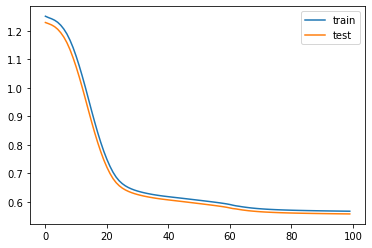

In [204]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [205]:
new_features = autoencoder.encoder.predict(X)

In [208]:
for i in range(new_features.shape[1]):
    df[f"New_{i+1}"] = new_features[:, i]
#     df.drop(columns=[f"New_{i+1}"], inplace=True)


In [209]:
df

,Date,price,ma7,ma21,26ema,12ema,MACD,upper_band,lower_band,STC,momentum,FT_10,FT_20,FT_40,New_1,New_2,New_3,New_4
0,1999-07-08,67.250000,67.250000,67.250000,67.250000,67.250000,0.000000,67.250000,67.250000,0.000000,66.250000,191.561244,217.281633,213.260196,41.503407,1082.884277,75.025284,322.815582
1,1999-07-09,67.250000,67.250000,67.250000,67.250000,67.250000,0.000000,67.250000,67.250000,0.000000,66.250000,190.988431,215.396836,208.871553,40.660221,1075.803711,75.171989,320.709106
2,1999-07-12,68.375000,67.625000,67.625000,67.423077,67.423077,0.089744,68.685660,66.564340,0.000000,67.375000,190.414449,213.505213,204.483193,39.083027,1071.589966,75.826820,320.017090
3,1999-07-13,67.875000,67.687500,67.687500,67.492604,67.492604,0.119147,68.631229,66.743771,0.000000,66.875000,189.839328,211.607214,200.098353,38.363834,1064.295654,75.776413,317.668335
4,1999-07-14,67.625000,67.675000,67.675000,67.512972,67.512972,0.120883,68.520577,66.829423,0.000000,66.625000,189.263098,209.703284,195.720260,37.571659,1056.848877,75.536507,315.512970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531,2021-06-30,379.529999,368.137137,372.918570,369.514629,369.514629,1.015709,394.800116,349.984882,20.755102,378.529999,194.406673,226.587730,235.094149,176.159500,3111.527832,309.726715,784.070801
5532,2021-07-01,374.989990,370.631422,372.516189,370.356992,370.356992,1.377253,392.877869,350.534128,60.377551,373.989990,193.840174,224.743698,230.752730,195.085526,3099.854248,256.353607,784.524902
5533,2021-07-02,374.160004,372.504281,371.822856,370.942071,370.942071,1.578608,390.037796,351.645199,80.188775,373.160004,193.272351,222.890634,226.395389,205.012222,3090.953857,232.189514,782.444763
5534,2021-07-06,369.859985,372.662850,370.794759,370.775596,370.775596,1.375354,387.400921,352.452072,64.998515,368.859985,192.703234,221.028975,222.025359,197.084274,3077.749268,249.412567,777.092590


### PCA

In [210]:
pca = PCA(n_components=.8)

In [214]:
x_pca = StandardScaler().fit_transform(df[df.columns[2:]].values)

In [215]:
principalComponents = pca.fit_transform(x_pca)

In [217]:
pca.n_components_

2

In [221]:
for i in range(principalComponents.shape[1]):
    df[f"PCA_{i+1}"] = principalComponents[:, i]

In [222]:
df

,Date,price,ma7,ma21,26ema,12ema,MACD,upper_band,lower_band,STC,momentum,FT_10,FT_20,FT_40,New_1,New_2,New_3,New_4,PCA_1,PCA_2
0,1999-07-08,67.250000,67.250000,67.250000,67.250000,67.250000,0.000000,67.250000,67.250000,0.000000,66.250000,191.561244,217.281633,213.260196,41.503407,1082.884277,75.025284,322.815582,-2.780984,1.357067
1,1999-07-09,67.250000,67.250000,67.250000,67.250000,67.250000,0.000000,67.250000,67.250000,0.000000,66.250000,190.988431,215.396836,208.871553,40.660221,1075.803711,75.171989,320.709106,-2.826304,1.368600
2,1999-07-12,68.375000,67.625000,67.625000,67.423077,67.423077,0.089744,68.685660,66.564340,0.000000,67.375000,190.414449,213.505213,204.483193,39.083027,1071.589966,75.826820,320.017090,-2.855171,1.383635
3,1999-07-13,67.875000,67.687500,67.687500,67.492604,67.492604,0.119147,68.631229,66.743771,0.000000,66.875000,189.839328,211.607214,200.098353,38.363834,1064.295654,75.776413,317.668335,-2.900911,1.389268
4,1999-07-14,67.625000,67.675000,67.675000,67.512972,67.512972,0.120883,68.520577,66.829423,0.000000,66.625000,189.263098,209.703284,195.720260,37.571659,1056.848877,75.536507,315.512970,-2.948533,1.397573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531,2021-06-30,379.529999,368.137137,372.918570,369.514629,369.514629,1.015709,394.800116,349.984882,20.755102,378.529999,194.406673,226.587730,235.094149,176.159500,3111.527832,309.726715,784.070801,10.921100,0.735854
5532,2021-07-01,374.989990,370.631422,372.516189,370.356992,370.356992,1.377253,392.877869,350.534128,60.377551,373.989990,193.840174,224.743698,230.752730,195.085526,3099.854248,256.353607,784.524902,10.832844,-0.505333
5533,2021-07-02,374.160004,372.504281,371.822856,370.942071,370.942071,1.578608,390.037796,351.645199,80.188775,373.160004,193.272351,222.890634,226.395389,205.012222,3090.953857,232.189514,782.444763,10.781179,-1.121469
5534,2021-07-06,369.859985,372.662850,370.794759,370.775596,370.775596,1.375354,387.400921,352.452072,64.998515,368.859985,192.703234,221.028975,222.025359,197.084274,3077.749268,249.412567,777.092590,10.698585,-0.649787
